In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

from torchsummary import summary

import matplotlib.pyplot as plt


In [2]:
import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import torch.nn.functional as F
from monai.networks.nets.resnet import resnet18
from monai.losses import DiceLoss
from src.models.unet3d.model_encoders import UNet3D


class SimCLR(pl.LightningModule):

    def __init__(self,
                 hidden_dim: int,
                 lr: float,
                 max_epochs: int,
                 img_dim: int,
                 temperature: float,
                 weight_decay: float,
                 encoder: UNet3D,
                 optimizer: torch.optim.Optimizer,
                 scheduler: torch.optim.lr_scheduler,
                 dice_weight: float = 0.5,
                 ):
        """_summary_

        Args:
            hidden_dim (int): number of neurons in the MLP head output aka dimensionality
                of feature vector
            lr (float): _description_
            img_dim (int): _description_
            temperature (float): _description_
            dice_weight (float): Weight of the dice term in the loss function.
                Between 0 and 1. Default: 0.5.
            weight_decay (float): _description_
            encoder (UNet3D): _description_
            optimizer (torch.optim.Optimizer): _description_
            scheduler (torch.optim.lr_scheduler): _description_
        """
        super().__init__()
        self.save_hyperparameters(ignore=['net', 'encoder'])

        self.dice_weight = dice_weight
        self.learning_rate = lr

        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'

        # extract information about last layer embedding dimension
        number_of_layers = len(encoder.f_maps)
        last_layer_kernels = encoder.f_maps[-1]

        # calculate u-net embeding dimension after max pooling
        embed_dim = int(last_layer_kernels * ((img_dim/(2)**(number_of_layers - 1))**3)/(2**3))

        self.unet = encoder
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.mlp_head = nn.Sequential(nn.Sequential(*encoder.encoders),
                                      nn.MaxPool3d(kernel_size=2, stride=2),
                                      nn.Flatten(),
                                      nn.Linear(embed_dim, embed_dim),
                                      nn.ReLU(inplace=False),
                                      nn.Linear(embed_dim, hidden_dim))
        # define the loss functions for segmentation and contrastive learning
        self.contrastive_loss = torch.nn.CrossEntropyLoss()
        
        self.dice_loss = DiceLoss(to_onehot_y=True, softmax=True,
                                  include_background=False)
        
        self.val_dsc = torchmetrics.Dice(ignore_index=0,
                                         average='macro',
                                         num_classes=3)
        self.train_dsc = torchmetrics.Dice(ignore_index=0,
                                           average='macro',
                                           num_classes=3)
        
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def forward(self, x):
        return self.mlp_head(x), self.unet(x)

    def info_nce_loss(self, batch, mode='train'):

        # NEW UN-BATCHING WITH LABELS
        img1, img2, lab1, lab2 = batch

        ########### InfoNCE Loss ###########
        imgs = torch.cat([img1, img2], dim=0)
        # Encode all images
        features = self.mlp_head(imgs)

        labels = torch.cat([torch.arange(batch[-1].shape[0], device=features.device) for i in range(2)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()

        features = F.normalize(features, dim=1)
        
        similarity_matrix = torch.matmul(features, features.T)

        # discard the main diagonal from both: labels and similarities matrix
        mask = torch.eye(labels.shape[0], dtype=torch.bool, device=similarity_matrix.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
        # assert similarity_matrix.shape == labels.shape

        # select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # select only the negatives the negatives
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long, device=logits.device)
        logits = logits / self.hparams.temperature

        contrastive_loss = self.contrastive_loss(logits, labels)


        ### DICE Loss ###
        lab1_pred = self.unet(img1)
        lab2_pred = self.unet(img2)
        
        dice1 = self.dice_loss(lab1_pred, lab1)
        dice2 = self.dice_loss(lab2_pred, lab2)
        
        dice_loss = dice1 + dice2
        
        final_loss = (1-self.dice_weight)*contrastive_loss + self.dice_weight*dice_loss
    
        # Logging loss
        self.log(mode+'_final_loss', final_loss, prog_bar=True)
        self.log(mode+'_dice_loss', dice_loss, prog_bar=True)
        self.log(mode+'_contrastive_loss', contrastive_loss, prog_bar=True)
        
        # top1, top5 = self.accuracy(logits, labels, topk=(1, 5))
        # # # Get ranking position of positive example


        # # Logging ranking metrics
        # self.log(mode+'_acc_top1', top1[0],
        #          prog_bar=True)
        # self.log(mode+'_acc_top5', top5[0],
        #          prog_bar=True)

        if mode == 'val':
            self.val_dsc(torch.concat([lab1_pred, lab2_pred]), torch.concat([lab1.squeeze(dim=1),   lab2.squeeze(dim=1)]))
            self.log(mode+'_dice', self.val_dsc.compute(), prog_bar=True,
                    on_step=True, on_epoch=True, batch_size=16, logger=True)
        elif mode == 'train':
            self.train_dsc(torch.concat([lab1_pred, lab2_pred]), torch.concat([lab1.squeeze(dim=1),   lab2.squeeze(dim=1)]))
            self.log(mode+'_dice', self.train_dsc.compute(), prog_bar=True,
                    on_step=True, on_epoch=True, batch_size=8, logger=True)
        return final_loss
        # return nll
    @staticmethod
    def accuracy(output, target, topk=(1,)):
        """Computes the accuracy over the k top predictions for the specified values of k"""
        with torch.no_grad():
            maxk = max(topk)
            batch_size = target.size(0)

            _, pred = output.topk(maxk, 1, True, True)
            pred = pred.t()
            correct = pred.eq(target.view(1, -1).expand_as(pred))

            res = []
            for k in topk:
                correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
                res.append(correct_k.mul_(100.0 / batch_size))
            return res
    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='val')


# Debug DataModule

In [3]:
import os
import random
import logging
from pathlib import Path

import torch
import numpy as np
import SimpleITK as sitk
import torch.utils.data as data
from pytorch_lightning import LightningDataModule
from monai.transforms import Affine

from src.utils.general import resample_volume
from src.data.splits import synthseg_sst_splits

logger = logging.getLogger(__name__)

# path to synstheg generated images and label maps folders
sytnthseg_orig_path = Path(os.environ['SYNTHSEG_PATH'])
sytnthseg2x2x2_path = Path(os.environ['SYNTHSEG2x2x2_PATH'])


class ContrastiveDataSet(data.Dataset):
    def __init__(self,
                 dataset: str,
                 split: str,
                 nviews:int = 2,
                 use_2x2x2_preproc: bool = True,
                 skull_strip: bool | float = True,
                 resample: list[float] | None = None,
                 ):
        """ContrastiveDataSet

        Args:
            dataset (str): Which dataset to use for contrastive learning.
                Available datasets: 'synthseg'.
            nviews (int, optional): How many agumented images of the same labelmap tp load . Defaults to 2.
            split (srt): Train or validation split.
            skull_strip (bool|float, optional): Whether to load skull-stripped images or not. 
                If a float given, removes the skull with a given probability.
                Defaults to True (always removes the skull & face).
            resample (list[x, y, z] | None, optional): Resample the images to a given resolution.

        """
        self.dataset = dataset
        self.nviews = nviews
        self.skull_strip = skull_strip
        self.resample = list(resample) if resample is not None else None
        self.split = split
        self.use_2x2x2_preproc = use_2x2x2_preproc
        self.transfrom = Affine(scale_params=(1.5, 1.5, 1.5))
        if dataset == 'synthseg':
            self._load_synthseg()
        else:
            raise ValueError(f'Unknown dataset: {dataset}')

    def __getitem__(self, index):
        img_path = self.img_dirs[index]
        all_img_views = [x for x in img_path.glob('image*.nii.gz')]
        views_paths = [all_img_views[random.randint(0,len(all_img_views)-1)]\
                        for i in range(self.nviews)]

        views_images = self._load_images(views_paths)

        return (views_images, -1)

    def __len__(self):
        return len(self.img_dirs)

    def _load_synthseg(self):
        if self.use_2x2x2_preproc:
            sytnthseg_path = sytnthseg2x2x2_path
        else:
            sytnthseg_path = sytnthseg_orig_path

        self.img_dirs = [x for x in sytnthseg_path.iterdir() if x.is_dir()]

        if self.split == 'train':
            self.img_dirs = [x for x in self.img_dirs if x.name not in synthseg_sst_splits['val']]
        elif self.split == 'val':
            self.img_dirs = [x for x in self.img_dirs if x.name in synthseg_sst_splits['val']]

    def _load_images(self, views_paths):

        # load images and convert to numpy
        images = [sitk.ReadImage(str(p)) for p in views_paths]
        images = [self._preporces_sitk(img) for img in images]
        images = [sitk.GetArrayFromImage(img) for img in images]

        # load labels and convert to numpy
        lable_paths = [str(x).replace('image', 'labels') for x in views_paths]
        labels = [sitk.ReadImage(p) for p in lable_paths]
        labels = [self._preporces_sitk(img, labelmap=True) for img in labels]
        labels = [sitk.GetArrayFromImage(img) for img in labels]

        # skull strip
        if self.skull_strip:
            # if skull_strip is a float, remove the skull with a given probability
            if random.random() < self.skull_strip:
                # mask out everything except cortex labels
                cortex_mask = [((x < 500) & (x != 0)).astype(np.int16) for x in labels]
                images = [x*y for x, y in zip(images, cortex_mask)]

        # min-max normalization
        images = [(i - i.min())/(i.max() - i.min()) for i in images]

        # convert to torch tensors and return
        images = [torch.tensor(i, dtype=torch.float32) for i in images]
        labels = [torch.tensor(i, dtype=torch.int64) for i in labels]
        
        # encode labels
        labels = [self._encode_segmentation(l) for l in labels]

        # squeeze the channel dimension
        images = [i.unsqueeze(0) for i in images]
        
        images[1] = self.transfrom(images[0])[0].to
        return images + labels

    def _encode_segmentation(self, img):
        # 0 - everything except, 1-GM (FreeSuerfer 3/42), 2-WM (FreeSurfer 2/41)
        img[(img != 3)&(img != 42)&(img != 2)&(img != 41)] = 0
        img[(img == 3)|(img == 42)] = 1
        img[(img == 2)|(img == 41)] = 2
        return img.unsqueeze(0)
    
    def _preporces_sitk(self, img, labelmap=False):
        image_interpolator = sitk.sitkLinear if not labelmap else sitk.sitkNearestNeighbor
        if self.resample is not None:
            img = resample_volume(img, self.resample, image_interpolator)
            return img
        else:
            return img


class ContrastiveDataModule(LightningDataModule):
    def __init__(self,
                 dataset_cfg,
                 train_batch_size: int,
                 validation_batch_size: int,
                 num_workers: int) -> None:
        super().__init__()
        self.dataset_cfg = dataset_cfg
        self.train_batch_size = train_batch_size
        self.validation_batch_size = validation_batch_size
        self.num_workers = num_workers

        self.train_dataset = ContrastiveDataSet(**dataset_cfg, split='train')

        self.val_dataset = ContrastiveDataSet(**dataset_cfg, split='val')

        logger.info(f'Len of train examples {len(self.train_dataset)} ' +
                    f'len of validation examples {len(self.val_dataset)}')

    def train_dataloader(self):
        return data.DataLoader(self.train_dataset,
                               batch_size=self.train_batch_size,
                               shuffle=True,
                               num_workers=self.num_workers,
                               drop_last=True,
                               pin_memory=True)

    def val_dataloader(self):
        return data.DataLoader(
            self.val_dataset,
            batch_size=self.validation_batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            drop_last=False,
            pin_memory=True)


In [4]:
dm = ContrastiveDataModule({'dataset':'synthseg',
                                        'nviews':2, 'skull_strip':True,
                                        'resample':None,
                                        'use_2x2x2_preproc':True},2,2,1)

dl = data.DataLoader(
            dm.train_dataset,
            batch_size=1,
            shuffle=False,
            num_workers=1,
            drop_last=False,
            pin_memory=False)

ds = dm.train_dataset

2023-03-16 11:45:51,090 - Len of train examples 16 len of validation examples 4


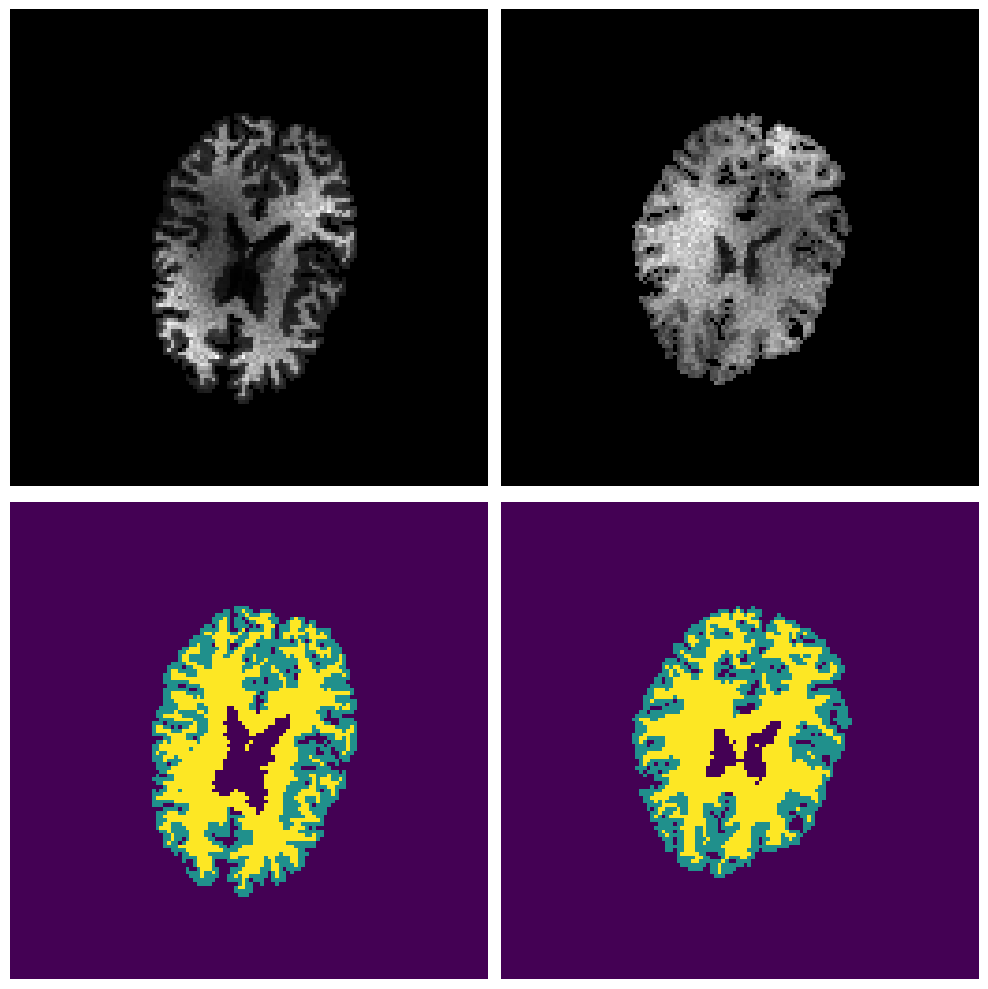

In [37]:
imgs = ds[6][0]

# plot the images
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(imgs[0][0, :, 65, :], cmap='gray')
ax[0, 1].imshow(imgs[1][0, :, 65, :], cmap='gray')
ax[0, 0].grid(False)
ax[0, 1].grid(False)
ax[0, 0].set_axis_off()
ax[0, 1].set_axis_off()
ax[1, 0].imshow(imgs[2][0, :, 65, :])
ax[1, 1].imshow(imgs[3][0, :, 65, :])
ax[1, 0].grid(False)
ax[1, 1].grid(False)
ax[1, 0].set_axis_off()
ax[1, 1].set_axis_off()
plt.tight_layout()
plt.show()

In [38]:
# encode labels 3 and 42 as GM
# and 2 and 41 as WM

In [39]:
# from torch.utils.data import default_collate
# import numpy as np

# a = [i*np.ones((1, 2, 2, 2)) for i in range(1,5)]
# b = [10*i*np.ones((1, 2, 2, 2)) for i in range(1, 5)]

# c = default_collate([a, b])

# print(len(c))

# c[0]

Now the training batch is a list of 4 elements each with the shape:
`torch.Size([batch_size, n_channels, X, Y, Z])`

First two elements are the input images, the last two are the segmentation masks corresponding to the input images.

```
4
torch.Size([3, 1, 128, 128, 128]) torch.Size([3, 1, 128, 128, 128])
torch.Size([3, 128, 128, 128]) torch.Size([3, 128, 128, 128])
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0) tensor(60)
tensor(0) tensor(60)
tensor(0.1865) tensor(0.2140)
tensor(0.0682) tensor(0.1144)
tensor(False)
```

# Estimate model parameters size

In [49]:
import torchsummary
import hydra

In [50]:
from src.models.unet3d.model_encodecoders import UNet3D

In [51]:
unetmodel = UNet3D(in_channels=1,
                   out_channels=3,
                   f_maps=[16, 32, 64, 128, 256, 512],
                   decoder_encoder=True)
model = SimCLR(hidden_dim=256,
                 lr=0.00001,
                 max_epochs=500,
                 img_dim=128,
                 temperature=0.07,
                 weight_decay=1e-4,
                 encoder=unetmodel,
                 optimizer=torch.optim.Adam,
                 scheduler= None,
                 dice_weight= 0.5)

Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.


In [52]:
sim_batch = [torch.stack([imgs[0], imgs[0]]), torch.stack([imgs[1], imgs[1]]), torch.stack([imgs[2], imgs[2]]), torch.stack([imgs[3], imgs[3]])]

In [54]:
model.training_step(sim_batch, 0)

You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tensor(1.7419, grad_fn=<AddBackward0>)

In [98]:
a = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
b = np.array([11, 132, 133, 0.14, 125, 2, 3, 14, 29, 60])
c = b**2
v1 = torch.tensor([c, a, b, 10*a, 20*a, a, b, b], dtype=torch.float32)
v2 = torch.tensor([(a+3)*20, b+1, 20*a, a, b, a+18, a+15, c], dtype=torch.float32)

In [99]:
v1.shape

torch.Size([8, 10])

In [100]:
similarities = F.cosine_similarity(v1, v2, dim=1)
argsimmax = torch.argmax(similarities)
argsimmax

tensor(3)

In [101]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

In [102]:
cos(v1, v2)

tensor([0.4505, 0.5060, 0.4987, 1.0000, 0.4987, 0.9360, 0.6447, 0.9833])

In [103]:
from torchmetrics.functional import pairwise_cosine_similarity

In [104]:
sim_mat = pairwise_cosine_similarity(v1, v2)
sim_mat

tensor([[0.4505, 0.9822, 0.3643, 0.3643, 0.9833, 0.5468, 0.5394, 1.0000],
        [0.9879, 0.5060, 1.0000, 1.0000, 0.4987, 0.9360, 0.9421, 0.3643],
        [0.5734, 1.0000, 0.4987, 0.4987, 1.0000, 0.6503, 0.6447, 0.9833],
        [0.9879, 0.5060, 1.0000, 1.0000, 0.4987, 0.9360, 0.9421, 0.3643],
        [0.9879, 0.5060, 1.0000, 1.0000, 0.4987, 0.9360, 0.9421, 0.3643],
        [0.9879, 0.5060, 1.0000, 1.0000, 0.4987, 0.9360, 0.9421, 0.3643],
        [0.5734, 1.0000, 0.4987, 0.4987, 1.0000, 0.6503, 0.6447, 0.9833],
        [0.5734, 1.0000, 0.4987, 0.4987, 1.0000, 0.6503, 0.6447, 0.9833]])

tensor([[7, 4, 1, 5, 6, 0, 2, 3],
        [2, 3, 0, 6, 5, 1, 4, 7],
        [4, 1, 7, 5, 6, 0, 2, 3],
        [2, 3, 0, 6, 5, 1, 4, 7],
        [2, 3, 0, 6, 5, 1, 4, 7],
        [2, 3, 0, 6, 5, 1, 4, 7],
        [4, 1, 7, 5, 6, 0, 2, 3],
        [4, 1, 7, 5, 6, 0, 2, 3]])